In [1]:
import time

import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Directory containing all the phone swing data
folder_containing_sensor_data = './data/'
sensor_parse_interval_ms = 30

## Step 1: Data Loading

This section will load in the sensor data, as well as interpolate the data at a regular interval, which is defined above.

In [3]:
# Organize files that contain the relevant data for each swing type
data = {
    'acc': {
        'Forehand': {
            'Good': {},
            'Bad': {}
        },
        'Backhand': {
            'Good': {},
            'Bad': {}
        },
        'Overhead': {
            'Good': {},
            'Bad': {}
        },
        'Passive': {
            'Good': {

            }
        }
    },
    'bar': {
        'Forehand': {
            'Good': {},
            'Bad': {}
        },
        'Backhand': {
            'Good': {},
            'Bad': {}
        },
        'Overhead': {
            'Good': {},
            'Bad': {}
        },
        'Passive': {
            'Good': {

            }
        }
    }
}

In [4]:
def load_data_file(file_path):
    accel_mode = True
    if 'bar' in file_path:
        accel_mode = False

    loaded_file_data = np.genfromtxt(file_path, dtype='double', delimiter=',')
    loaded_file_data[:, 0] = loaded_file_data[:, 0] - loaded_file_data[0][0]

    new_timestamps = np.arange(0, loaded_file_data[:,0][-1], sensor_parse_interval_ms, dtype='int64')

    # Now, we interpolate the data to be on a common time axis
    if accel_mode:
        new_x = np.interp(x=new_timestamps, xp=loaded_file_data[:,0], fp=loaded_file_data[:,1])
        new_y = np.interp(x=new_timestamps, xp=loaded_file_data[:,0], fp=loaded_file_data[:,2])
        new_z = np.interp(x=new_timestamps, xp=loaded_file_data[:,0], fp=loaded_file_data[:,3])
        aligned_data = np.column_stack((new_timestamps, new_x, new_y, new_z))

    else:
        new_bar = np.interp(x=new_timestamps, xp=loaded_file_data[:,0], fp=loaded_file_data[:,1])
        aligned_data = np.column_stack((new_timestamps, new_bar))

    return aligned_data

In [5]:
all_data_files = glob.glob(os.path.join(folder_containing_sensor_data, '*'))

start_time = time.time()
for data_file in all_data_files:
    swing_success = 'Good'
    data_file_name_only = data_file.split('/')[-1][:-4]
    data_file_name_only = data_file_name_only.split('\\')[1]
    method, swing_type, timestamp = data_file_name_only.split('_')[:3]

    # Mark as bad if necessary
    if len(data_file_name_only.split('_')) >= 4:
        swing_success = 'Bad'

    data[method][swing_type][swing_success][timestamp] = load_data_file(data_file)
end_time = time.time()

print(f"Loaded Data from {len(all_data_files)//2} Swings in {(end_time-start_time):.2f} Seconds")

Loaded Data from 534 Swings in 4.38 Seconds


## Step 2: Visualize the data

Now that the data has been recorded, it is time to create the classifier.

In [24]:
# This prints out one swing acc data, first is time, x, y, z
print(data['acc']['Backhand']['Good']['1650304011612'][0])


[ 0.          1.0097656  -0.89730835  9.944565  ]


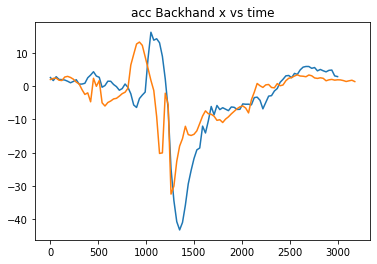

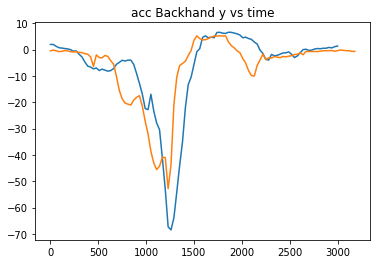

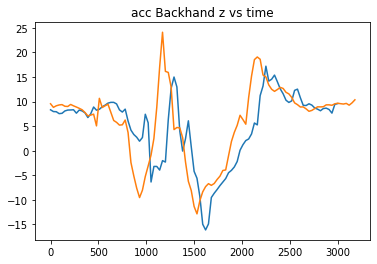

In [7]:
# change num_data to change number of graphs
num_data = 2
sensor = 'acc'
swing = 'Backhand'
isGood = 'Good'

time_stamps = [key for key, value in data[sensor][swing][isGood].items()]
for i in range(num_data):
    time = [t_stamp[0] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    x = [t_stamp[1] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    plt.figure(0)
    plt.plot(time, x)
    plt.title(sensor + " " + swing + " " + "x vs time")

for i in range(num_data):
    time = [t_stamp[0] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    y = [t_stamp[2] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    plt.figure(1)
    plt.plot(time, y)
    plt.title(sensor + " " + swing + " " + "y vs time")
    
for i in range(num_data):
    time = [t_stamp[0] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    z = [t_stamp[3] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    plt.figure(2)
    plt.plot(time, z)
    plt.title(sensor + " " + swing + " " + "z vs time")

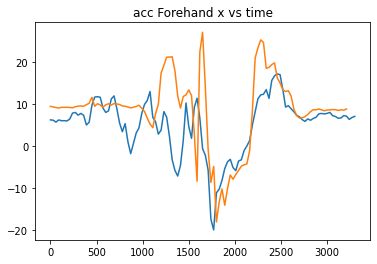

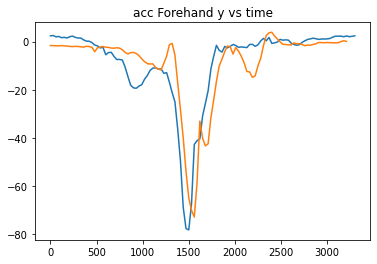

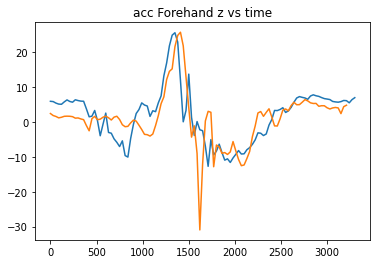

In [8]:
# change num_data to change number of graphs
num_data = 2
sensor = 'acc'
swing = 'Forehand'
isGood = 'Good'

time_stamps = [key for key, value in data[sensor][swing][isGood].items()]
for i in range(num_data):
    time = [t_stamp[0] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    x = [t_stamp[1] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    plt.figure(0)
    plt.plot(time, x)
    plt.title(sensor + " " + swing + " " + "x vs time")

for i in range(num_data):
    time = [t_stamp[0] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    y = [t_stamp[2] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    plt.figure(1)
    plt.plot(time, y)
    plt.title(sensor + " " + swing + " " + "y vs time")
    
for i in range(num_data):
    time = [t_stamp[0] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    z = [t_stamp[3] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    plt.figure(2)
    plt.plot(time, z)
    plt.title(sensor + " " + swing + " " + "z vs time")

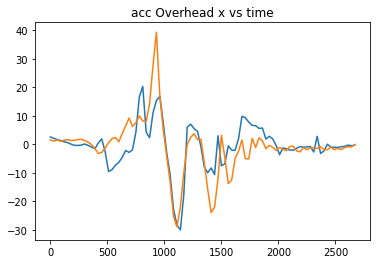

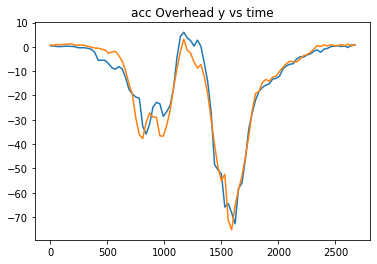

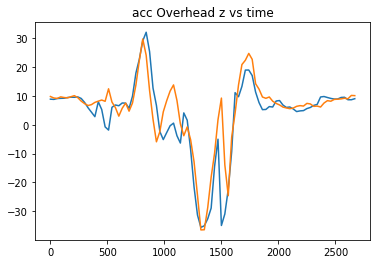

In [9]:
# change num_data to change number of graphs
num_data = 2
sensor = 'acc'
swing = 'Overhead'
isGood = 'Good'

time_stamps = [key for key, value in data[sensor][swing][isGood].items()]
for i in range(num_data):
    time = [t_stamp[0] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    x = [t_stamp[1] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    plt.figure(0)
    plt.plot(time, x)
    plt.title(sensor + " " + swing + " " + "x vs time")

for i in range(num_data):
    time = [t_stamp[0] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    y = [t_stamp[2] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    plt.figure(1)
    plt.plot(time, y)
    plt.title(sensor + " " + swing + " " + "y vs time")
    
for i in range(num_data):
    time = [t_stamp[0] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    z = [t_stamp[3] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    plt.figure(2)
    plt.plot(time, z)
    plt.title(sensor + " " + swing + " " + "z vs time")

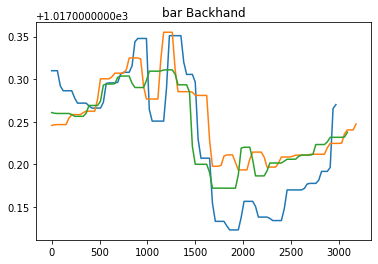

In [10]:
# change num_data to change number of graphs
num_data = 3
sensor = 'bar'
swing = 'Backhand'
isGood = 'Good'

time_stamps = [key for key, value in data[sensor][swing][isGood].items()]
for i in range(num_data):
    time = [t_stamp[0] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    x = [t_stamp[1] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    plt.figure(0)
    plt.plot(time, x)
    plt.title(sensor + " " + swing)


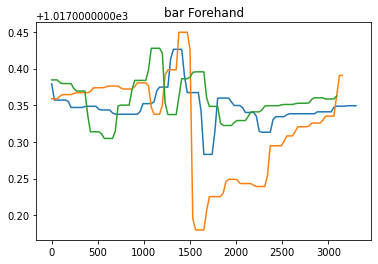

In [11]:
# change num_data to change number of graphs
num_data = 3
sensor = 'bar'
swing = 'Forehand'
isGood = 'Good'

time_stamps = [key for key, value in data[sensor][swing][isGood].items()]
for i in range(num_data):
    time = [t_stamp[0] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    x = [t_stamp[1] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    plt.figure(0)
    plt.plot(time, x)
    plt.title(sensor + " " + swing)


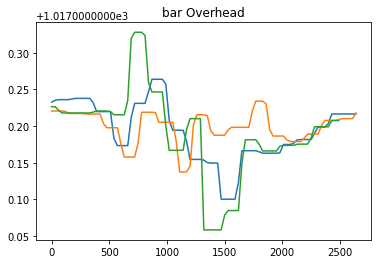

In [12]:
# change num_data to change number of graphs
num_data = 3
sensor = 'bar'
swing = 'Overhead'
isGood = 'Good'

time_stamps = [key for key, value in data[sensor][swing][isGood].items()]
for i in range(num_data):
    time = [t_stamp[0] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    x = [t_stamp[1] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    plt.figure(0)
    plt.plot(time, x)
    plt.title(sensor + " " + swing)


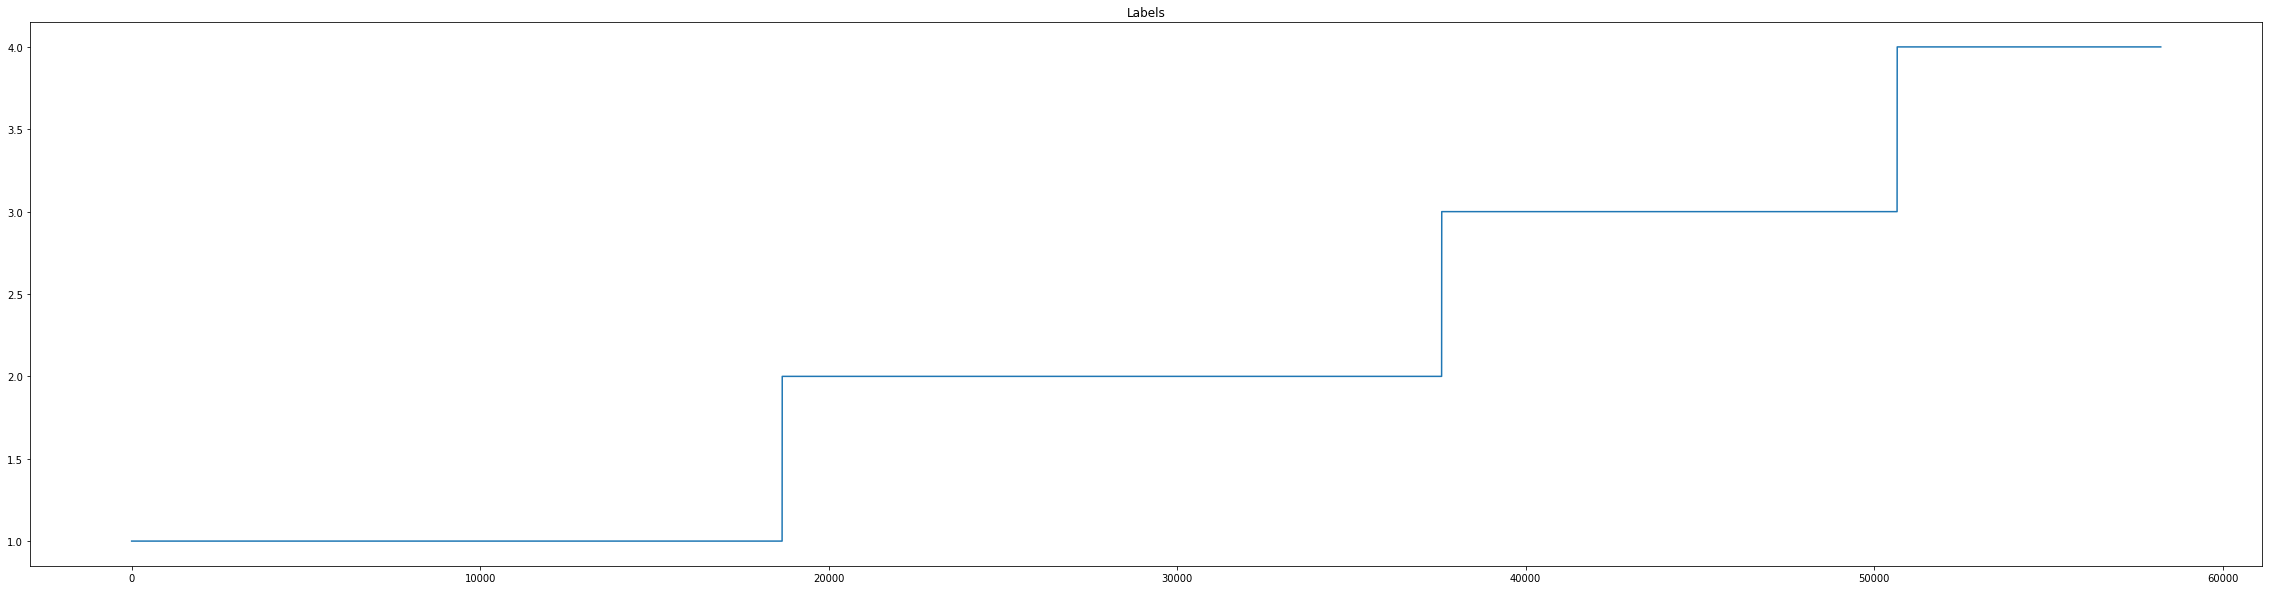

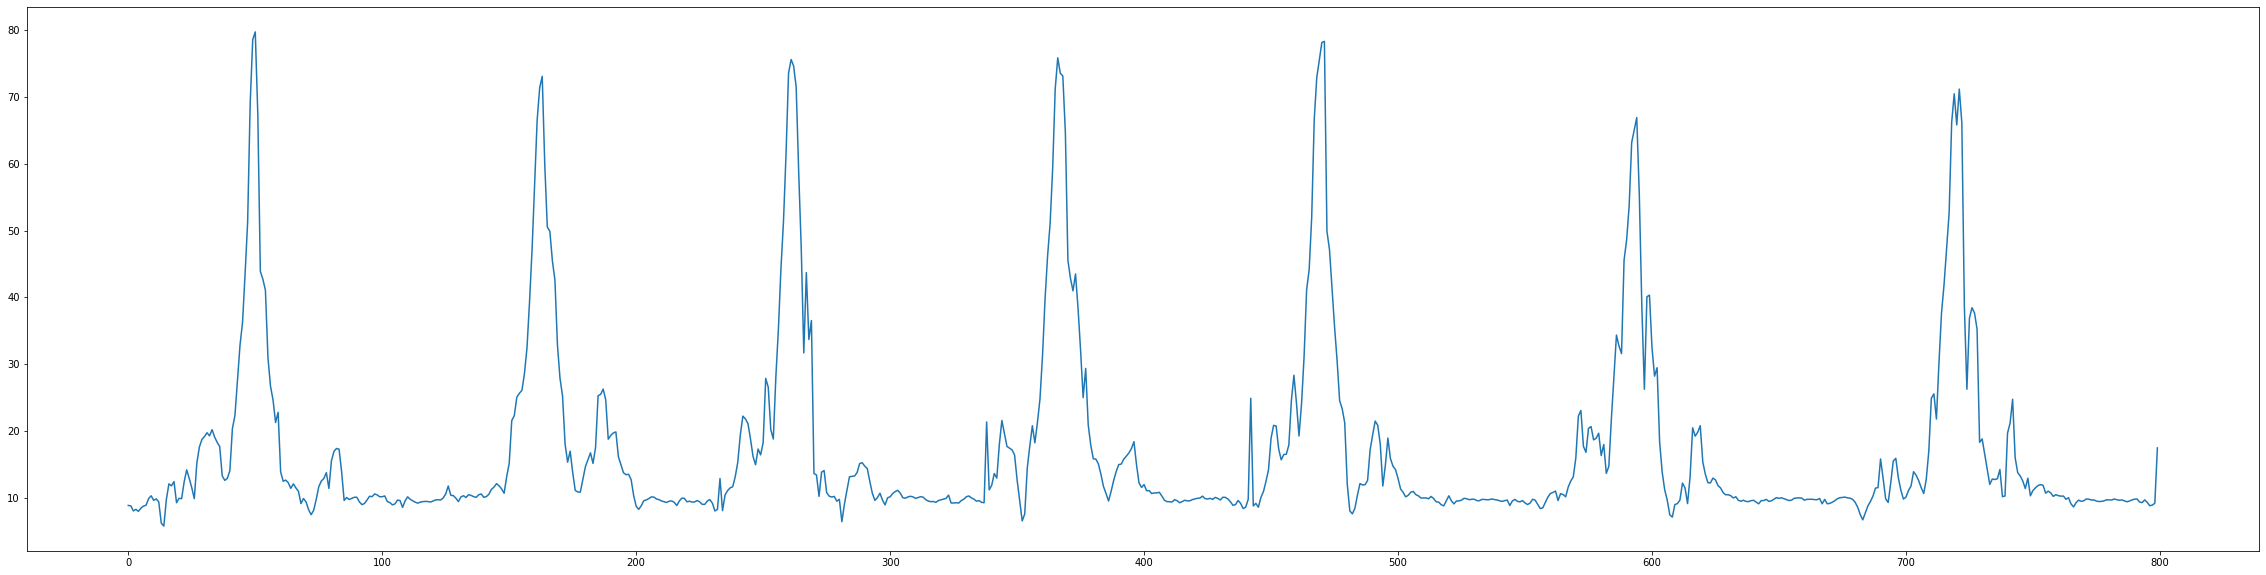

In [55]:
# Visualize the magnitude of the 3D accelerometer values
import math

sensor = 'acc'
swings = ['Forehand', 'Backhand', 'Overhead', 'Passive']
isGood = 'Good'
# forehand label 1, backhand label 2, overhead label 3, passive label 4
activity_label_acc = []
activity_label_bar = []
acc_mag = []
bar_mag = []

for idx, swing in enumerate(swings):
    for key, value in data[sensor][swing][isGood].items():
        for acc_data in value:
            acc_mag.append( math.sqrt(acc_data[1]**2 + acc_data[2]**2 + acc_data[3]**2) )
            activity_label_acc.append(idx+1)
        for bar_data in data['bar'][swing][isGood][key]:
            bar_mag.append(bar_data[1])
            activity_label_bar.append(idx+1)

plt.figure(0, figsize=(40,10))
plt.plot(list(range(len(activity_label_acc))), activity_label_acc)
plt.title("Labels")

temp = 800
plt.figure(1, figsize=(40,10))
# plt.plot(list(range(len(activity_label_acc))), acc_mag)
plt.plot(list(range(temp)), acc_mag[0:temp])

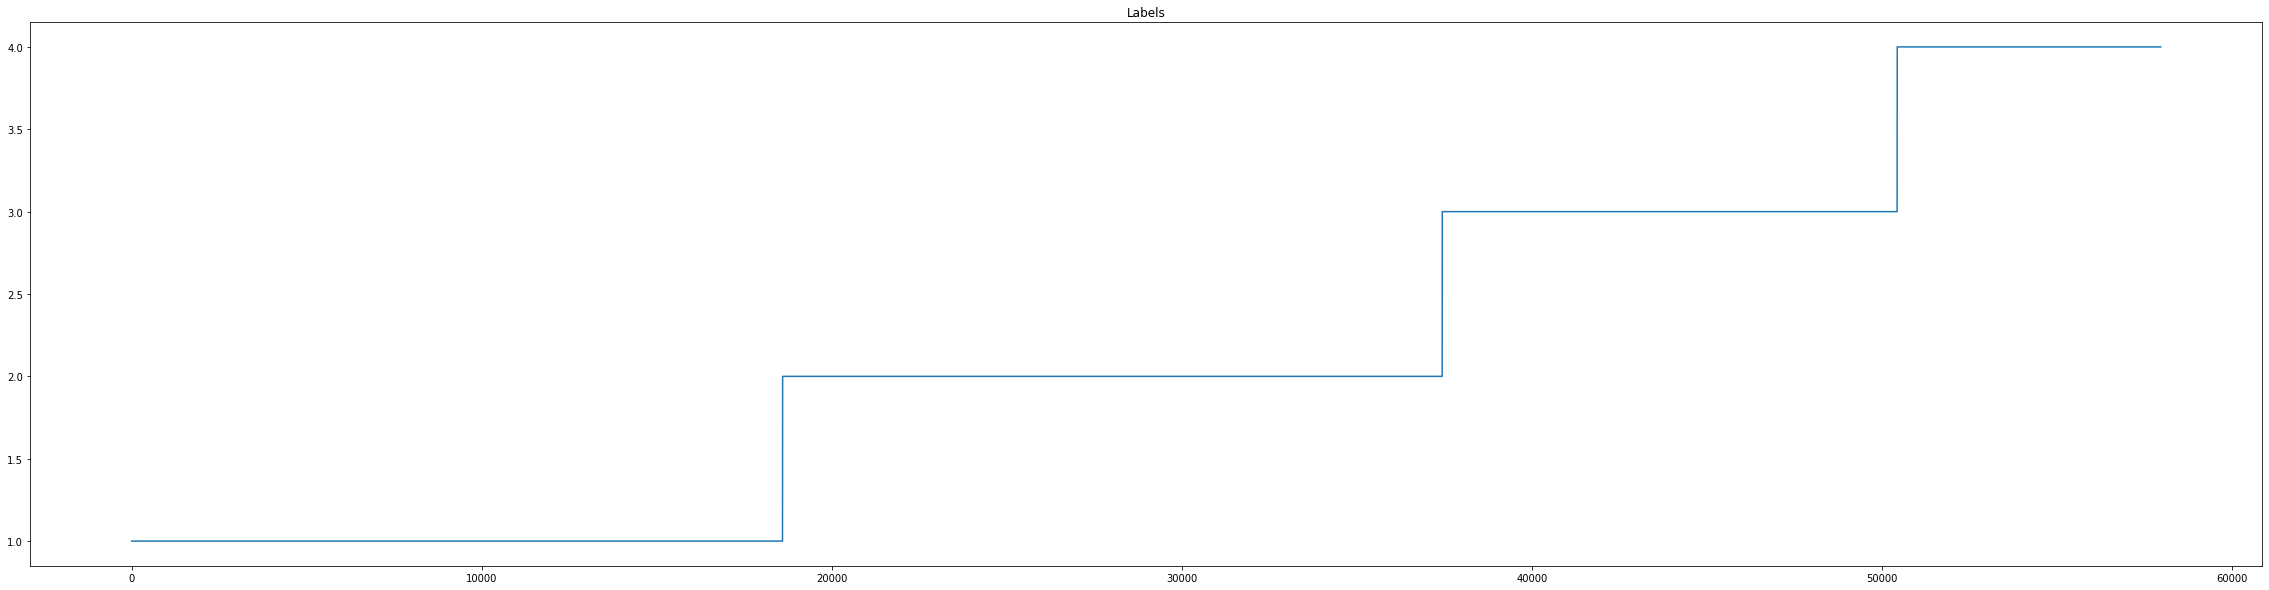

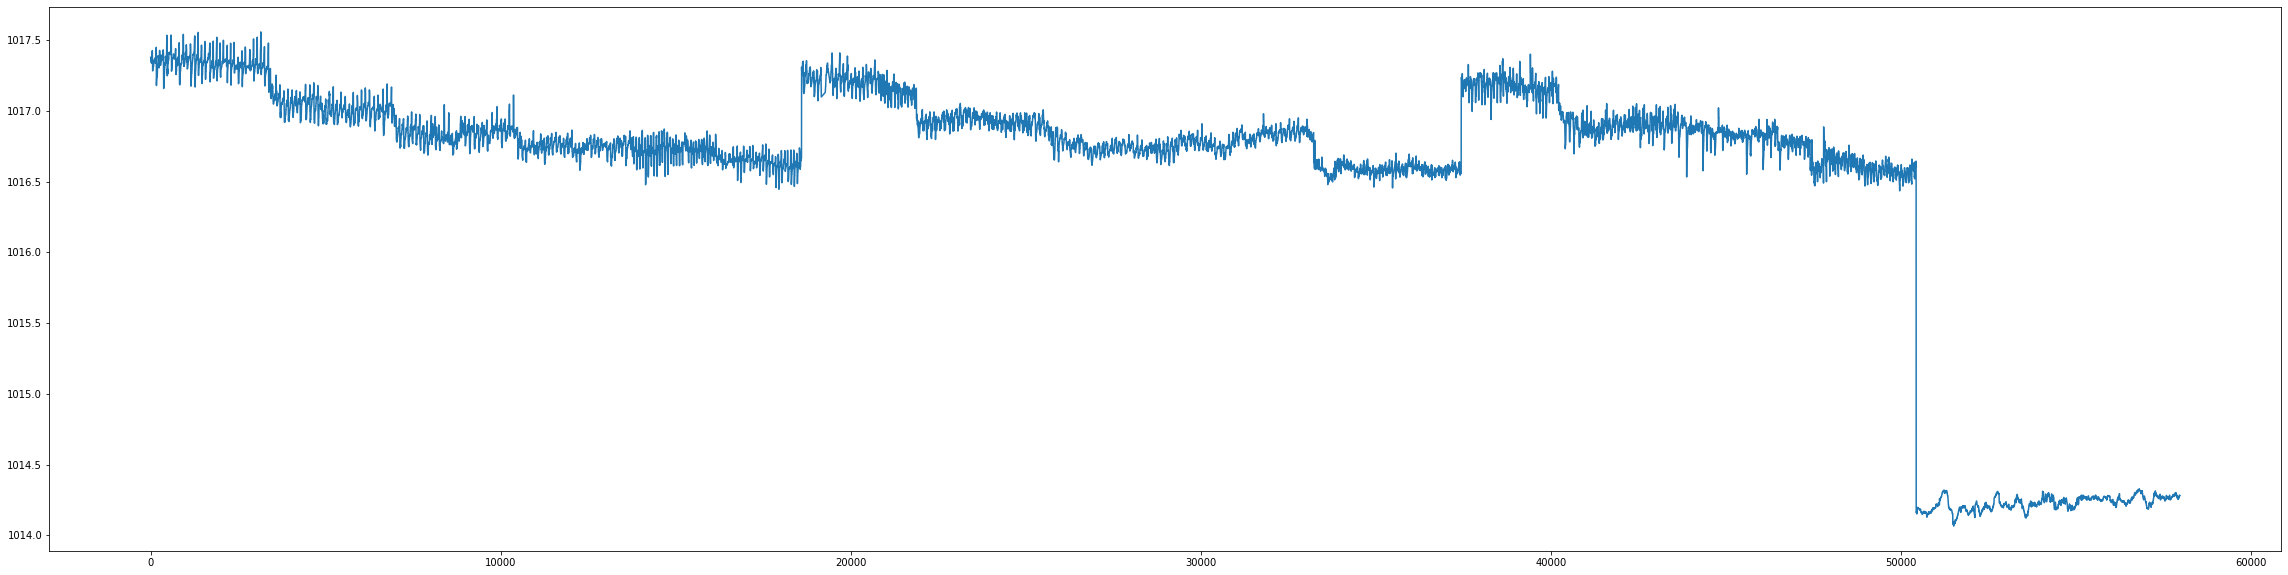

In [37]:
plt.figure(0, figsize=(40,10))
plt.plot(list(range(len(activity_label_bar))), activity_label_bar)
plt.title("Labels")

plt.figure(1, figsize=(40,10))
plt.plot(list(range(len(activity_label_bar))), bar_mag)